# Multi-class Image Classification with Transfer Learning and TensorFlow

## Introduction 

You are walking down the street and you meet a four legged stranger...

In [1]:
# Load image
from IPython.display import Image
from IPython.core.display import HTML 
# Image(url= "https://www.hdwallpaper.nu/wp-content/uploads/2015/03/Long-Haired-Golden-Retriever.jpg", unconfined=True)

# Uncomment the remaining lines of code for a smaller image
html1 = '<img src="https://www.hdwallpaper.nu/wp-content/uploads/2015/03/Long-Haired-Golden-Retriever.jpg" width="460" height="360" align="center"/>'
HTML(html1)

"Sooooo Cute!" <br>
"What's their name?" <br>
"How old are they?" <br>
<br>

Like some people, you may also ask, "what kind of breed is that?" <br>  

But, there will always be someone other than the owner who knows that our little friend is a golden retriever. 
<br> <br>

How do they know that? Answering this question is the purpose of this notebook. <br> <br>  

To do this, I will use data from Kaggle which has over 10,000 labelled images of 120 different dog breeds. This is multi-class image classification as we are classifying multiple dog breeds from images.

For the model, I will be using a pretrained model from TensorFlow Hub. This is transfer learning, which leverages the parallelism between this dataset and a model that has been trained to classify images.


## Data

Import data

In [2]:
!wget https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip # download files from Dropbox as zip

import os
import zipfile

local_zip = 'dog-breed-identification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('Dog Vision') # unzip the files into a file called "Dog Vision"
zip_ref.close()

--2020-12-22 19:27:15--  https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip [following]
--2020-12-22 19:27:15--  https://www.dropbox.com/s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d4b20397e111e1902a12794c3.dl.dropboxusercontent.com/cd/0/inline/BFmQv6zJOUgcfNoy57PVZWD8DhDaAnccOBvOAAIMRSt_LZG9Crtq9mbr6K5hMR2MUvn2e72fdx9SAuBLANnkAQ4Ryp4QAe1u8MvdN14XWZRQ3VlM4G0IfQw_BMszLjGkFfw/file# [following]
--2020-12-22 19:27:16--  https://uc8d4b20397e111e1902a12794c3.dl.dropboxusercontent.com/cd/0/inline/BFmQv6zJOUgcfNoy57PVZWD8DhDaAnccOBvOAAIMRSt_LZG9Crtq9mbr6K5h

Check the data labels

The labels.csv file assumes that there are 120 unique dog breeds and 10222 images. The label with the fewest number of images is acceptable since there are over 60 images. A golden standard based on the Google Cloud Platform is 10 images.

In [3]:
import pandas as pd

labels = pd.read_csv("Dog Vision/labels.csv")

print(labels.describe())
print(labels.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     67697bfe65210a526eac7881ce19deac  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


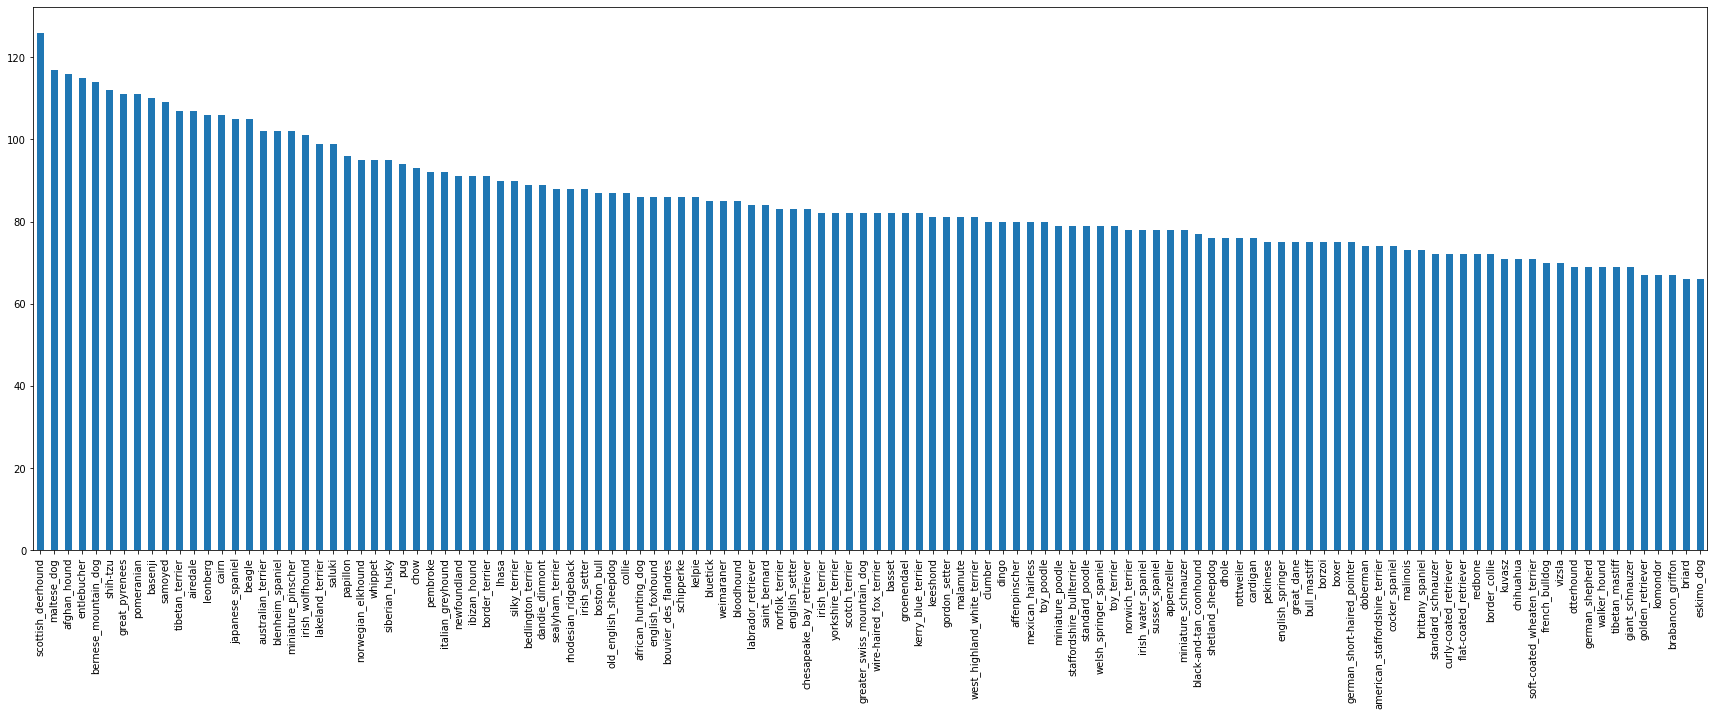

In [4]:
import matplotlib.pyplot as plt

labels.breed.value_counts().plot.bar(figsize = (30, 10))
plt.show()

We still need to compare the number of images and the number of labels to see that is one-to-one.

In [5]:
# Turn the dataframe into a NumPy array
import numpy as np
label = labels.breed.to_numpy()
label[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [6]:
# List every image as a string describing its path
imageNames = ["Dog Vision/train/" + name + ".jpg" for name in labels.id]
imageNames[:15]

['Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'Dog Vision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'Dog Vision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'Dog Vision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'Dog Vision/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg',
 'Dog Vision/train/0075dc49dab4024d12fafe67074d8a81.jpg']

In [7]:
# Take the ratio between the number of images to the number of labels
len(imageNames) / len(label)

1.0

In [8]:
totalBreeds = np.unique(label)

# Number of bars in the plot above
len(totalBreeds)

120

In [9]:
# Turn labels into array of bools
boolLabels = [name == np.array(totalBreeds) for name in label]

A True in the array means that the the label identifies the image as the dog breed in the respective index. The rest of the array would be False.

### Train test split to create a validation dataset

In [10]:
X = imageNames
y = boolLabels

# Choose the number of images with a slider, starting small is best practice since training takes a long time
IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:IMAGES], y[:IMAGES], test_size = 0.2, random_state = 69)

# Check dimensions
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

As always, we want to work with numbers so this array must be converted into an array of integers but in this case matching and not matching is binary. A 1 would be a match while a 0 is not a match across all the features. We can map the index of the max value, the 1, to the same index in the labels list of dog breeds.

### Preprocessing images with TensorFlow 2.0 to turn the data into tensors

In [11]:
# Import TF 2.x if it is not defaulted on Colab
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

Check if TensorFlow and the Hub are available

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Runtime > Change runtime type > Hardware Accelerator > GPU
print("GPU available!" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.4.0
Hub version: 0.10.0
not available :(


In [13]:
# Image -> Numpy array
from matplotlib.pyplot import imread
image = imread(imageNames[420]) # read in an image
image.shape

(375, 500, 3)

The shape is defined as (height, width, number of color channels per pixel). Here, each pixel is RGB.

In [14]:
# Numpy array -> Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[114, 113, 131],
        [103, 102, 120],
        [113, 112, 130],
        ...,
        [219, 211, 175],
        [195, 187, 151],
        [235, 227, 191]],

       [[112, 111, 129],
        [107, 106, 124],
        [111, 110, 128],
        ...,
        [224, 215, 184],
        [201, 192, 161],
        [233, 224, 193]]], dtype=uint8)>

In [15]:
# The pre-trained model on TensorFlow Hub uses (224,224) as the image size
imageSize = 224

def imageConvert(imageNames):
  """
  Takes an image filename as input
  Read the file and save it
  Turn the image which is a jpeg into Tensors
  Resize image to model image shape (imageSize)
  Return modified image
  """
  image = tf.io.read_file(imageNames)
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size = [imageSize, imageSize])
  return image

Creating a data batch to compute on smaller portions of data is benenficial here since there are over 10,000 images. Also, one can find patterns in a batch at a time rather than in an entire dataset. Trying to compute on all of the images can result in an error if the calcualtion requires more memory than the GPU. Batches of Tesnors are given in the form of a tuple, (image, label). We can modulate tuple and batch creation as functions.

In [16]:
# Return tuple
def batchIdentifier(imageNames, label):
  image = imageConvert(imageNames)
  return image, label

In [17]:
# Batch size 32 since that is Deep God Lecun's default
batchSize = 32

def genBatch(x, y = None, batchSize = batchSize, validData = False, testData = False):
  """
  Accomodates training, validation and test data
  Images = x, Labels = y
  Prints type of batch
  If training data, shuffle the data
  Return batch
  """
  # Test
  # There are no labels
  if testData:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    dataBatch = data.map(imageConvert).batch(batchSize)
    return dataBatch

  # Validation
  # Do not shuffle
  elif validData:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(batchIdentifier).batch(batchSize)
    return data_batch

  # Training
  # Shuffle
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size = len(x))
    data = data.map(batchIdentifier)
    data_batch = data.batch(batchSize)
    return data_batch

In [18]:
# Create training and validation data batches
train_data = genBatch(X_train, y_train)
val_data = genBatch(X_val, y_val, validData=True)

Creating training data batches...
Creating validation data batches...


In [19]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Modeling

On TensorFlow Hub, look for image classification models. I chose:

Imagenet (ILSVRC-2012-CLS) classification with MobileNet V2 (depth multiplier 1.40).

https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4

The input image shape is (224,224).
The output shape is the number of unique labels.

In [22]:
# [batch, height, width, number of color channels]
inputShape = [None, imageSize, imageSize, 3] 

# Number of breeds
outputShape = len(totalBreeds)

# Model URL
modelURL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4"

Build a Keras model
* Take in a input shape, ouptut shape and the model URL
* Define layers sequentially (sequential API)
* Compile, build, return the model
> Layers: <br>
> "First" - Input layer, model from TensorFlow Hub (many layers). Takes in images and finds patterns based on the pre-trained model patterns. <br>
> "Second" - Ouput layer, outputs input layer discoveries in shape



In [25]:
def createModel(inputShape = inputShape, outputShape = outputShape, modelURL = modelURL):
  print("Building model with:", modelURL)

  # [input layer, output layer]
  model = tf.keras.Sequential([hub.KerasLayer(modelURL), 
                               tf.keras.layers.Dense(units = outputShape, activation = "softmax")]) # Softmax instead of sigmoid to assgin a probabilty to each breed since this is not binary classification

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), # Improve confusion matrix
                optimizer = tf.keras.optimizers.Adam(), # Adam algorithm rather than stochastic gradient descent
                metrics = ["accuracy"])
  
  model.build(inputShape)

  return model